# Network Visualization

In [29]:
# Define custom names
custom_names_dict = {
"Anxiety": {
-1: "Stress Sleep",
0: "Community Support",
1: "Home Relations",
2: "Work Stress",
3: "Panic Symptoms",
4: "ADHD Medication",
5: "Family Issues",
6: "Uncertainty Skepticism",
7: "Friendship Struggles",
8: "Medication Effects",
9: "Withdrawal Challenges",
10: "Sleep Coping",
11: "Cognitive Symptoms"
},
"Depression": {
-1: "Past Losses",
0: "Community Sharing",
1: "Family Drains",
2: "Low Energy",
3: "Bipolar Medication",
4: "Anxiety Sadness",
5: "Financial Stress"
},
"PTSD and trauma": {
-1: "Childhood Abuse",
0: "Support Skepticism",
1: "Family Abuse",
2: "Therapy Healing Fears",
3: "Abusive Hurt Protection",
4: "Childhood Anger Trust",
5: "Financial Strain",
6: "Pain Flashback Anger",
7: "Masked Trauma",
8: "Sexual Abuse",
9: "Family Hurt"
},
"Suicidal thoughts and self-harm": {
-1: "Suicidal Pain Advice",
0: "Self-Harm Support",
1: "Suicidal Loss",
2: "Hesitant Pain Skepticism",
3: "Family Hurt Trust",
4: "Safety Plan Trusts",
5: "Inner Struggles",
6: "Parental Conflict",
7: "OCD Night Safety",
8: "Financial Stress",
9: "Workplace Strain",
10: "Lonely Family",
11: "Hopelessness"
}
}

platform = "beyondblue"
labels = ["Anxiety", "Depression", "PTSD and trauma", "Suicidal thoughts and self-harm"]

In [31]:
import pickle
import os
import numpy as np


# Load saved data
data_dir = './data/network_graph'
with open(os.path.join(data_dir, 'G.gpickle'), 'rb') as f:
    G = pickle.load(f)
sim_matrix = np.load(os.path.join(data_dir, 'sim_matrix.npy'))
coherence_matrix = np.load(os.path.join(data_dir, 'coh_matrix.npy'))
embeddings = np.load(os.path.join(data_dir, 'embeddings.npy'))
with open(os.path.join(data_dir, 'all_subtopics.pkl'), 'rb') as f:
    all_subtopics = pickle.load(f)

In [30]:
import os
import numpy as np
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
from bertopic import BERTopic
import networkx as nx
from collections import defaultdict
from gensim.models.coherencemodel import CoherenceModel
from gensim.corpora.dictionary import Dictionary
import pickle

def load_model_and_subtopics(platform, label, custom_names):
    """Load BERTopic model and subtopic info with topic embeddings."""
    path = os.path.join(os.getcwd(), 'data', f'{platform}_data', 'berttopic_label', label)
    try:
        topic_model = BERTopic.load(os.path.join(path, f'{label}_berttopic'))
    except Exception as e:
        print(f"Error loading model for label '{label}': {e}")
        return []
    
    # Get topic assignments and info
    topic_info = topic_model.get_topic_info()
    topic_keywords = {t: topic_model.get_topic(t) for t in topic_info.Topic if t != -1}
    doc_counts = topic_info.set_index("Topic")["Count"].to_dict()
    # Total number of documents assigned to this label (excluding outliers)
    total_label_docs = sum([count for tid, count in doc_counts.items() if tid != -1])
    
    
    # Get topic embeddings (excluding -1 if present)
    topic_embeddings = topic_model.topic_embeddings_
    topic_ids = sorted([t for t in topic_keywords.keys()])  # Only valid topics
    if len(topic_embeddings) != len(topic_info):
        print(f"Warning: Mismatch between topic embeddings ({len(topic_embeddings)}) and topics ({len(topic_info)}) for label '{label}'.")
    
    subtopics = []
    for topic_id in topic_ids:
        keywords = [(kw, score) for kw, score in topic_keywords[topic_id]]
        doc_indices = [i for i, t in enumerate(topic_model.topics_) if t == topic_id]
        if not doc_indices:
            print(f"Warning: No documents assigned to topic {topic_id} in label '{label}'.")
            continue
        # Map topic_id to embedding index (assuming embeddings align with topic IDs)
        embedding_idx = topic_id + 1 if topic_id >= 0 else 0  # Adjust for -1 if present
        if embedding_idx >= len(topic_embeddings):
            print(f"Warning: No embedding for topic {topic_id} in label '{label}'.")
            continue
        subtopics.append({
            'model_label': label,
            'topic_id': topic_id,
            'name': custom_names.get(topic_id, f"{label}_{topic_id}"),
            'keywords': keywords,
            'doc_indices': doc_indices,
            'doc_count': doc_counts.get(topic_id, 0),
            'embedding': topic_embeddings[embedding_idx],
            'total_label_docs': total_label_docs
        })
    
    return subtopics

def build_full_graph(platform, labels, custom_names_dict):
    all_subtopics = []
    
    for label in labels:
        custom_names = custom_names_dict.get(label, {})
        subtopics = load_model_and_subtopics(platform, label, custom_names)
        if not subtopics:
            print(f"Skipping label '{label}' due to loading issues.")
            continue
        all_subtopics.extend(subtopics)
    
    if not all_subtopics:
        print("Error: No subtopics available for graph building.")
        return nx.Graph(), None, None, []
    
    embeddings = np.array([t['embedding'] for t in all_subtopics])
    sim_matrix = cosine_similarity(embeddings)
    
    # Prepare proxy corpus and dictionary for coherence
    all_keywords = [[kw for kw, _ in t['keywords'][:10]] for t in all_subtopics]
    dictionary = Dictionary(all_keywords)

    def paired_coherence(topic1_keywords, topic2_keywords, top_n=10):
        combined = list(set([kw for kw, _ in topic1_keywords[:top_n]] + [kw for kw, _ in topic2_keywords[:top_n]]))
        if len(combined) < 2:
            return 0.0
        cm = CoherenceModel(topics=[combined], texts=all_keywords, dictionary=dictionary, coherence='c_v')
        return cm.get_coherence()

    # Create full G with all edges
    G = nx.Graph()

    # Add nodes
    for idx, topic in enumerate(all_subtopics):
        relative_size = topic['doc_count'] / topic['total_label_docs']
        G.add_node(
            idx,
            label=topic['model_label'],
            name=topic['name'],
            keywords=', '.join([kw for kw, _ in topic['keywords'][:10]]),
            size=relative_size,
            true_doc_count=topic['doc_count']
        )

    # Initialize coherence matrix for efficiency
    n = len(all_subtopics)
    coherence_matrix = np.zeros((n, n))

    # Track min/max for sim and coherence
    sim_values = []
    coherence_values = []

    # First loop: Add edges with weight (coherence * sim) and original_sim; store coherence
    for i in range(n):
        for j in range(i + 1, n):
            sim = sim_matrix[i, j]
            coherence = paired_coherence(all_subtopics[i]['keywords'], all_subtopics[j]['keywords'])
            coherence_matrix[i, j] = coherence
            coherence_matrix[j, i] = coherence
            sim_values.append(sim)
            coherence_values.append(coherence)
            weight = coherence * sim  # 1st weight: coherence * sim
            G.add_edge(i, j, weight=weight, original_sim=sim)  # 3rd: original_sim (sim)

    # Compute min/max
    sim_min = min(sim_values) if sim_values else 0.0
    sim_max = max(sim_values) if sim_values else 1.0
    coh_min = min(coherence_values) if coherence_values else 0.0
    coh_max = max(coherence_values) if coherence_values else 1.0

    print(f"Similarity range: min = {sim_min:.4f}, max = {sim_max:.4f}")
    print(f"Coherence range: min = {coh_min:.4f}, max = {coh_max:.4f}")

    # Second loop: Compute and add nor_weight (nor(coherence) * nor(sim))
    for i in range(n):
        for j in range(i + 1, n):
            sim = sim_matrix[i, j]
            coherence = coherence_matrix[i, j]
            # Normalize
            sim_norm = (sim - sim_min) / (sim_max - sim_min) if sim_max != sim_min else 1.0
            coherence_norm = (coherence - coh_min) / (coh_max - coh_min) if coh_max != coh_min else 1.0
            # 2nd weight: nor_weight
            nor_weight = sim_norm * coherence_norm
            G[i][j]['nor_weight'] = nor_weight  # Add nor_weight to edge

    return G, sim_matrix, coherence_matrix, embeddings, all_subtopics

# Run Part 1: Build full graph
G, sim_matrix, coherence_matrix, embeddings, all_subtopics = build_full_graph(platform, labels, custom_names_dict)

# Save to ./data/network_graph
os.makedirs('./data/network_graph', exist_ok=True)
with open('./data/network_graph/G.gpickle', 'wb') as f:
    pickle.dump(G, f, pickle.HIGHEST_PROTOCOL)
np.save('./data/network_graph/sim_matrix.npy', sim_matrix)
np.save('./data/network_graph/embeddings.npy', embeddings)
np.save('./data/network_graph/coh_matrix.npy', coherence_matrix)
with open('./data/network_graph/all_subtopics.pkl', 'wb') as f:
    pickle.dump(all_subtopics, f)

d:\miniconda3\envs\MDS1\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Similarity range: min = 0.9678, max = 0.9991
Coherence range: min = 0.0301, max = 0.6215


C:\Users\user\AppData\Local\Temp\ipykernel_31396\1159456630.py:19: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = get_cmap("tab10", len(labels))


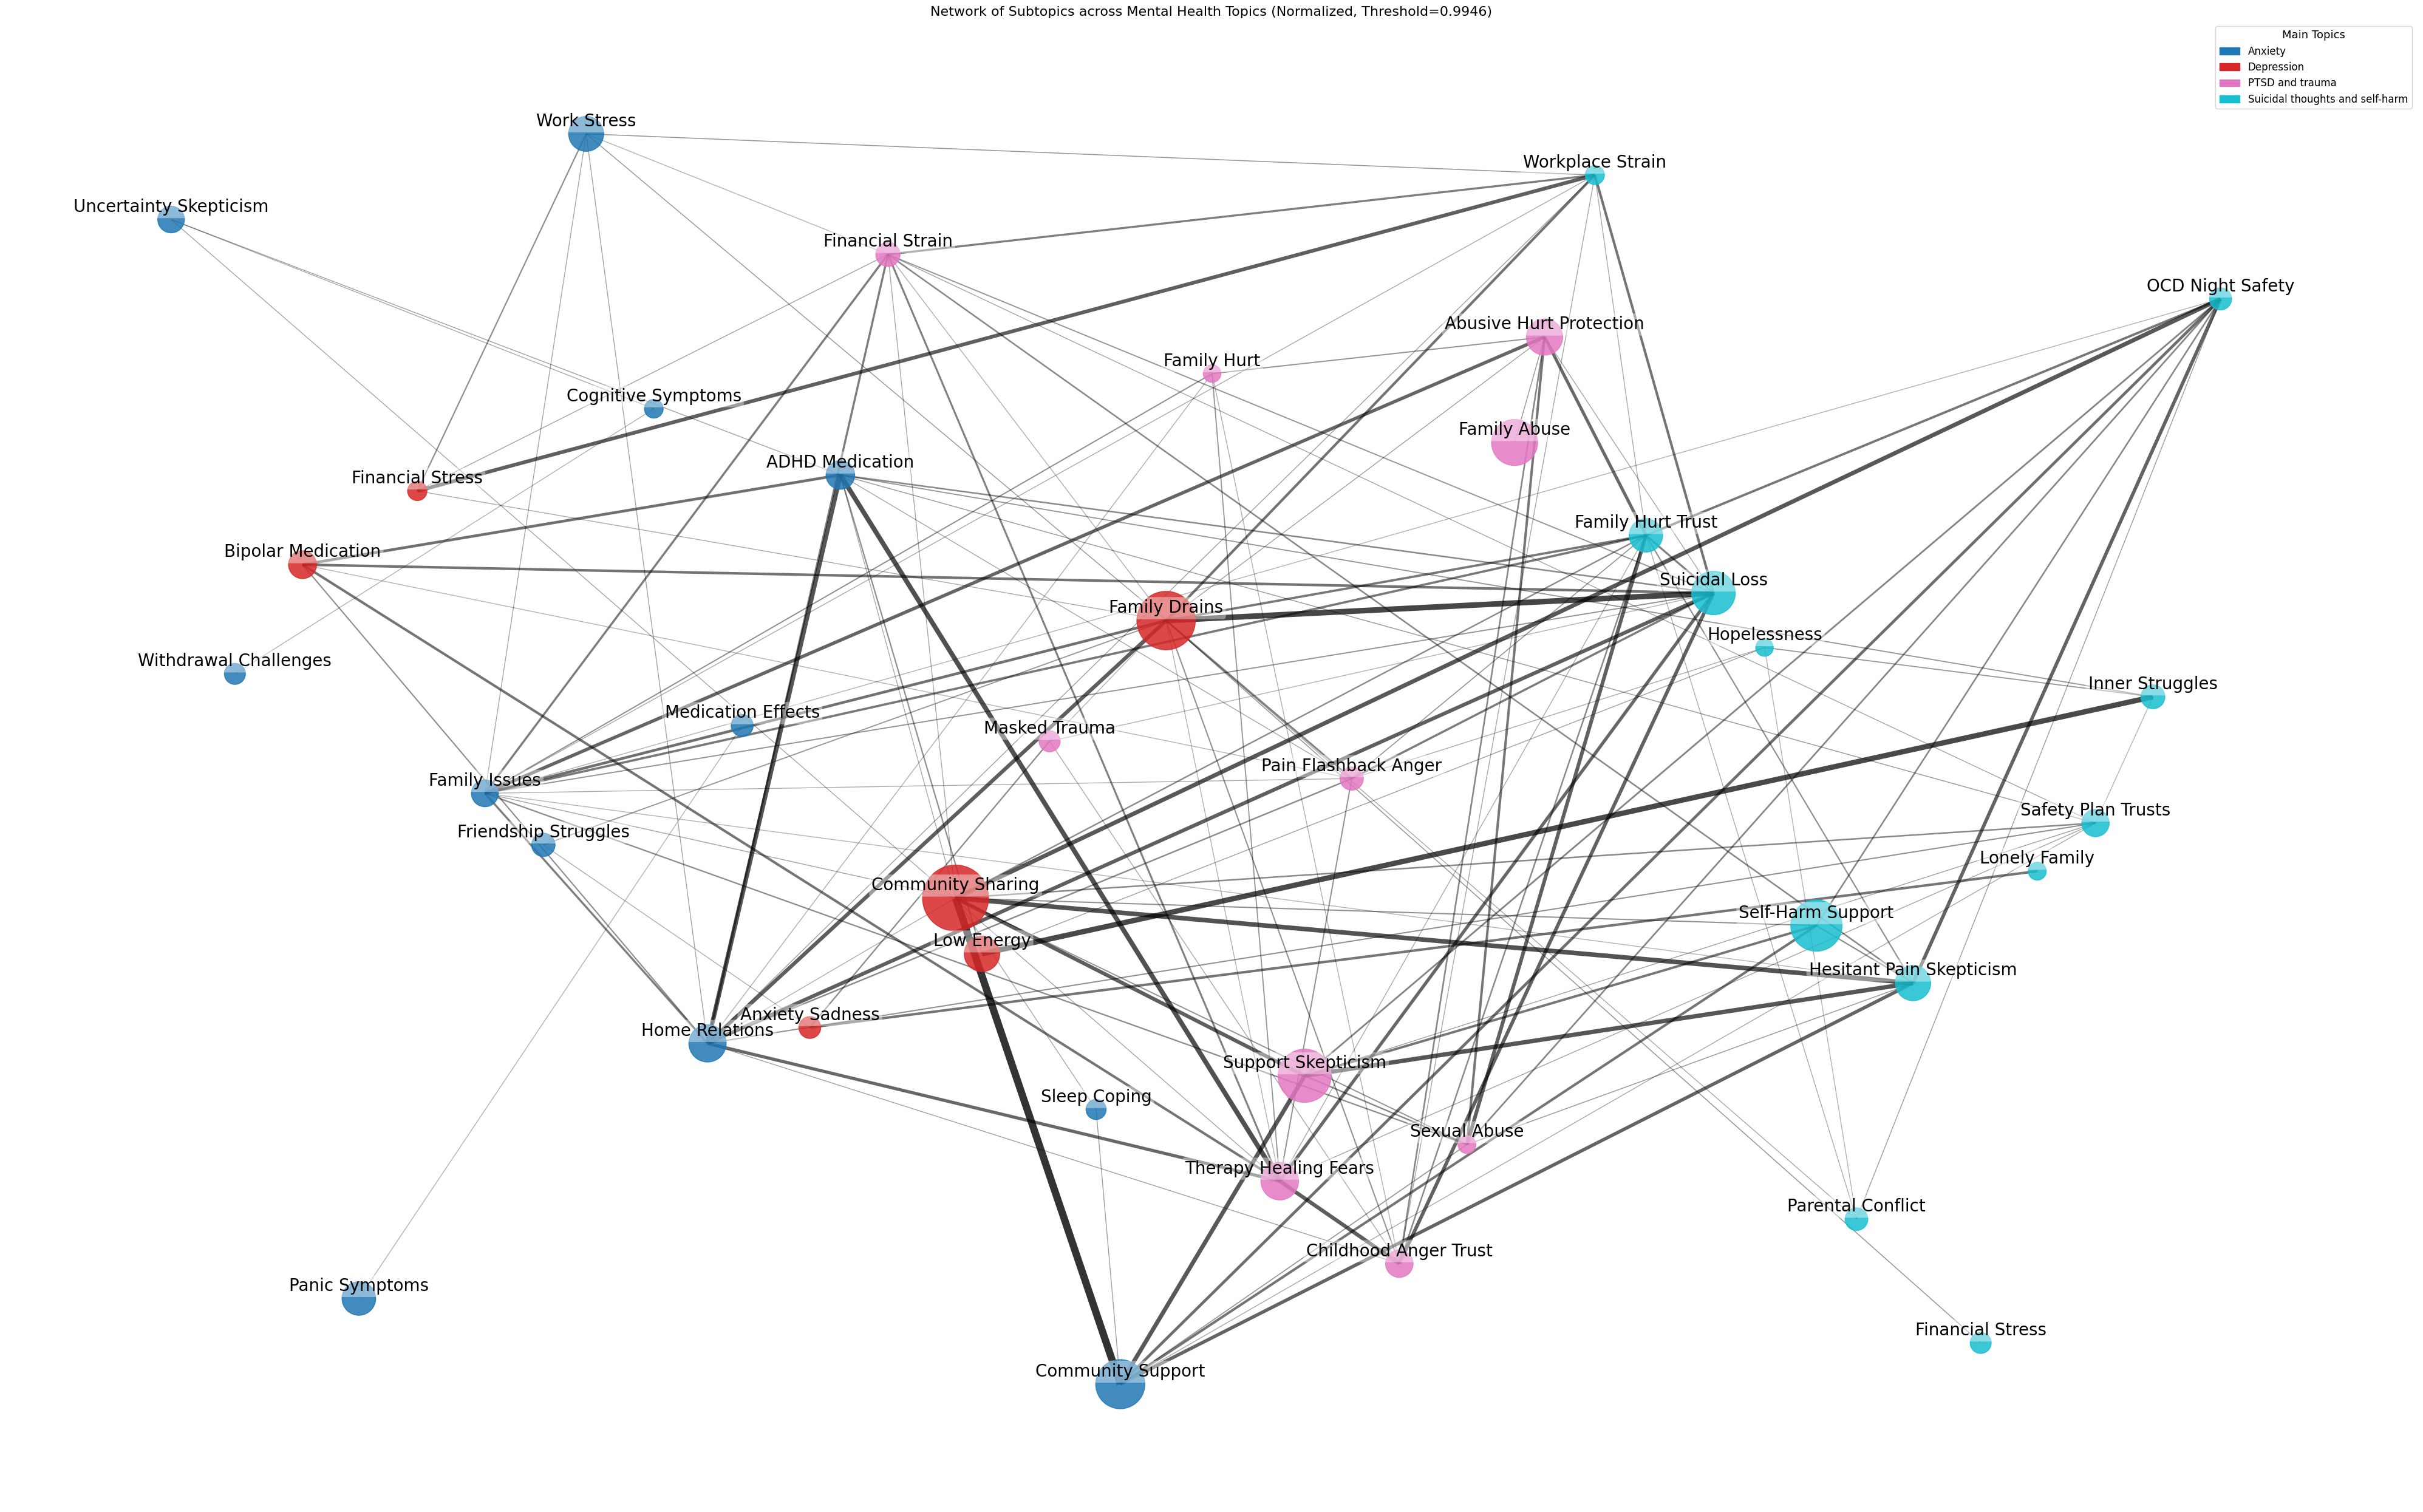

In [55]:
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
import matplotlib.patches as mpatches
from sklearn.preprocessing import MinMaxScaler
import networkx as nx
import numpy as np



def plot_graph(G, labels,weight_type, threshold=0.9, pos=None):
    # Create a new graph with all nodes from G
    filtered_G = nx.Graph()
    
    # Add all nodes with their attributes
    for n, data in G.nodes(data=True):
        filtered_G.add_node(n, **data)

    # Add colors to nodes (requires labels)
    cmap = get_cmap("tab10", len(labels))
    label_color = {label: cmap(i) for i, label in enumerate(labels)}
    for n in filtered_G.nodes:
        filtered_G.nodes[n]['color'] = label_color[filtered_G.nodes[n]['label']]

    # Add edges where original_sim >= threshold
    filtered_edges = [(u, v, d) for u, v, d in G.edges(data=True) if d.get(weight_type, 0) >= threshold]
    for u, v, d in filtered_edges:
        filtered_G.add_edge(u, v, **d)








    if pos is None:
        # Graph layout clustering by main topic
        pos = {}
        horizontal_scale = 1.5  # Increased horizontal separation
        vertical_scale = 2.5  # Increased vertical scale
        np.random.seed(42)  # For reproducible perturbations
        for i, label in enumerate(labels):
            nodes = [n for n, d in filtered_G.nodes(data=True) if d["label"] == label]
            subgraph = filtered_G.subgraph(nodes)
            # Dynamic offset based on number of nodes, increased factor
            offset_step = 12.0 * (len(nodes) / 10.0)
            sub_pos = nx.circular_layout(subgraph, scale=1.5)  # Increased scale
            
            for k in sub_pos:
                # Apply scaling for elliptical shape
                sub_pos[k][0] *= horizontal_scale
                sub_pos[k][1] *= vertical_scale
                sub_pos[k][0] += i * offset_step
            pos.update(sub_pos)

        # Add position enforcement
        def enforce_minimum_axis_distances(pos, min_dx=3.0, min_dy=3.0, max_iter=100):
            """Ensure nodes are at least `min_dx` apart in x and `min_dy` apart in y."""
            for _ in range(max_iter):
                moved = False
                nodes = list(pos.keys())
                for i in range(len(nodes)):
                    for j in range(i + 1, len(nodes)):
                        node_i, node_j = nodes[i], nodes[j]
                        xi, yi = pos[node_i]
                        xj, yj = pos[node_j]
                        dx = abs(xi - xj)
                        dy = abs(yi - yj)
                        
                        if dx < min_dx:
                            # Push apart in x direction
                            shift_x = (min_dx - dx) / 2
                            if xi > xj:
                                pos[node_i] = (xi + shift_x, yi)
                                pos[node_j] = (xj - shift_x, yj)
                            else:
                                pos[node_i] = (xi - shift_x, yi)
                                pos[node_j] = (xj + shift_x, yj)
                            moved = True
                        
                        if dy < min_dy:
                            # Push apart in y direction
                            shift_y = (min_dy - dy) / 2
                            if yi > yj:
                                pos[node_i] = (xi, yi + shift_y)
                                pos[node_j] = (xj, yj - shift_y)
                            else:
                                pos[node_i] = (xi, yi - shift_y)
                                pos[node_j] = (xj, yj + shift_y)
                            moved = True
                
                if not moved:
                    break
            return pos

        # Apply minimum axis distance enforcement
        pos = enforce_minimum_axis_distances(pos, min_dx=3.0, min_dy=4.5)





    # Draw the graph
    plt.figure(figsize=(40, 25))  # Increased figure size
    
    node_sizes = [filtered_G.nodes[n]['size'] * 15000 for n in filtered_G.nodes]  # normalized & scaled
    node_colors = [filtered_G.nodes[n]['color'] for n in filtered_G.nodes]
    
    if filtered_G.edges:
        edge_weights = [filtered_G[u][v][weight_type] for u, v in filtered_G.edges]
        # Scale weights to range [1, 15] with emphasis on higher similarities
        scaler = MinMaxScaler(feature_range=(1, 15))
        scaled_weights = scaler.fit_transform(np.array(edge_weights).reshape(-1, 1)).flatten()
        # Apply exponential scaling to emphasize differences
        scaled_weights = [2.5 * (np.exp(w / 10) - 1) for w in scaled_weights]
        # Ensure minimum visibility and cap maximum width
        scaled_weights = [min(max(w, 1.0), 12.0) for w in scaled_weights]
        # Adjust alpha for edges based on weight
        edge_alphas = [0.3 + 0.5 * ((w - min(edge_weights)) / (max(edge_weights) - min(edge_weights) + 1e-6)) for w in edge_weights]
    else:
        scaled_weights = []
        edge_alphas = []

    nx.draw_networkx_nodes(filtered_G, pos, node_size=node_sizes, node_color=node_colors, alpha=0.85)
    for (u, v), width, alpha in zip(filtered_G.edges, scaled_weights, edge_alphas):
        nx.draw_networkx_edges(filtered_G, pos, edgelist=[(u, v)], width=width, alpha=alpha)

    for node, (x, y) in pos.items():
        plt.text(
            x, y + 0.4,  # Increased upward shift
            filtered_G.nodes[node]['name'],
            fontsize=20,  # Increased font size
            ha='center',
            va='bottom',
            color='black',
            bbox=dict(boxstyle='round,pad=0.15', fc='white', ec='none', alpha=0.4)
        )
    
    legend_handles = [
        mpatches.Patch(color=label_color[label], label=label)
        for label in labels
    ]
    plt.legend(
        handles=legend_handles,
        loc="upper right",
        fontsize=12,
        title="Main Topics",
        title_fontsize=13
    )

    plt.title(f"Network of Subtopics across Mental Health Topics (Normalized, Threshold={threshold})", fontsize=16)
    plt.axis("off")
    plt.tight_layout()
    plt.show()

    return filtered_G, pos

# Run Part 2: Plot with threshold
norweight_threshold = 0.2
sim_threshold = 0.9946
filtered_G, pos = plot_graph(G, labels, threshold=sim_threshold, weight_type = "original_sim")

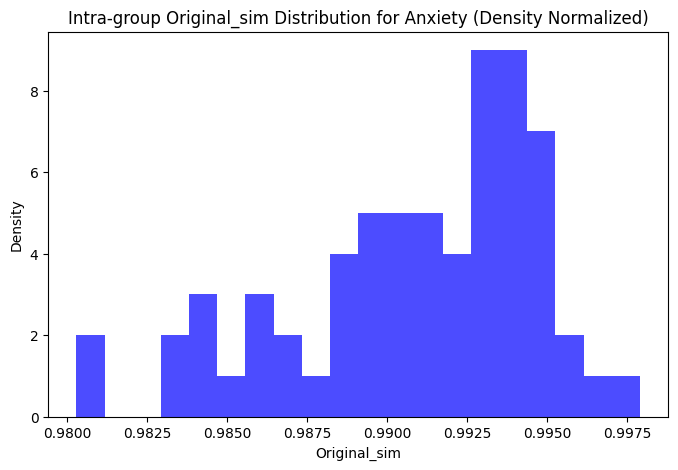

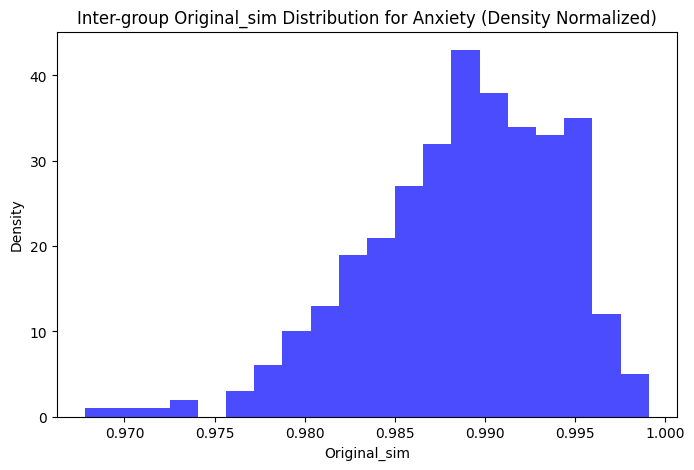

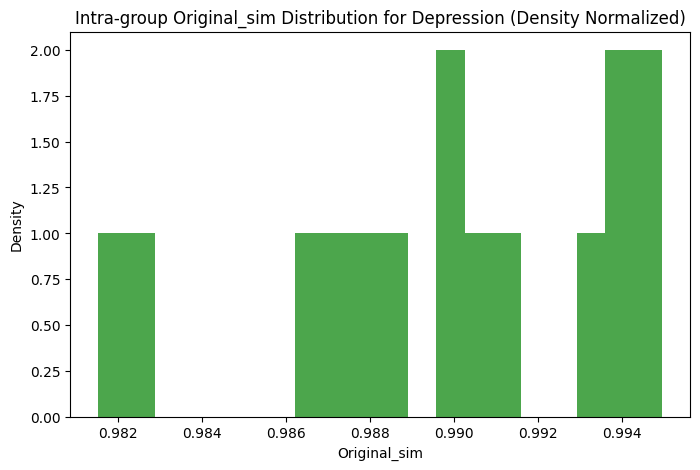

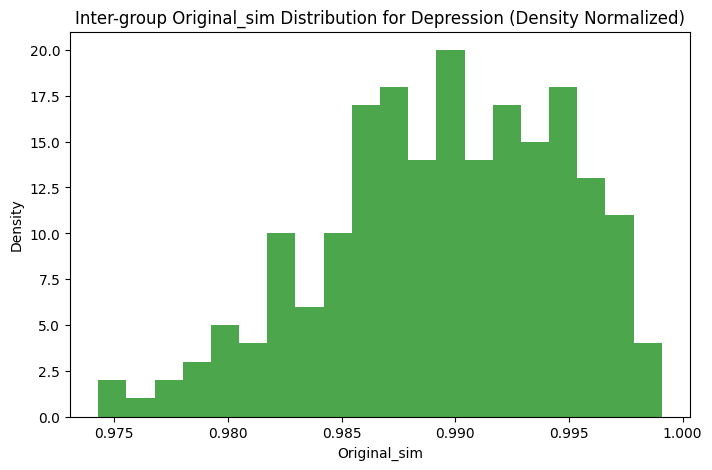

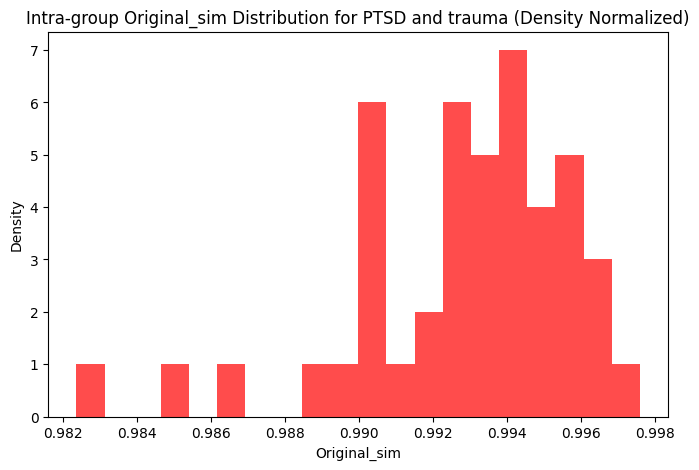

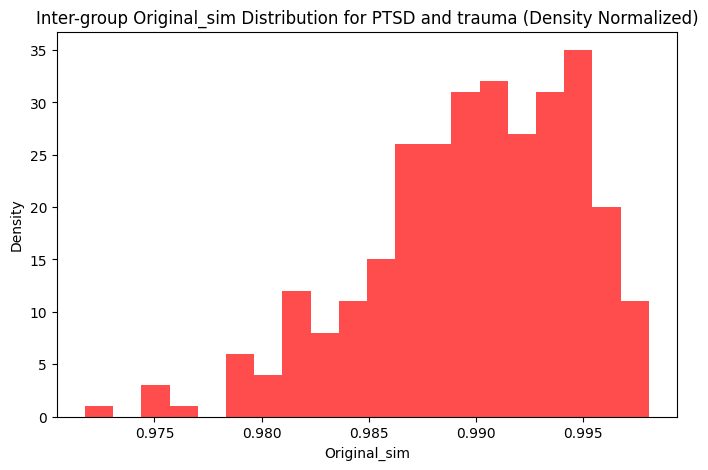

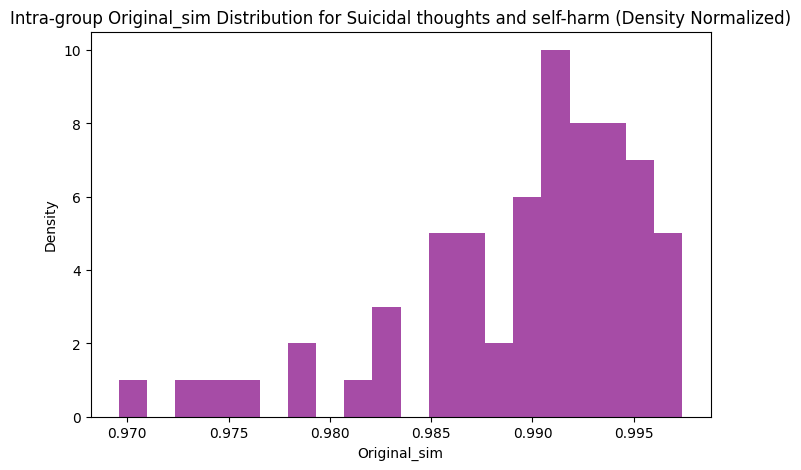

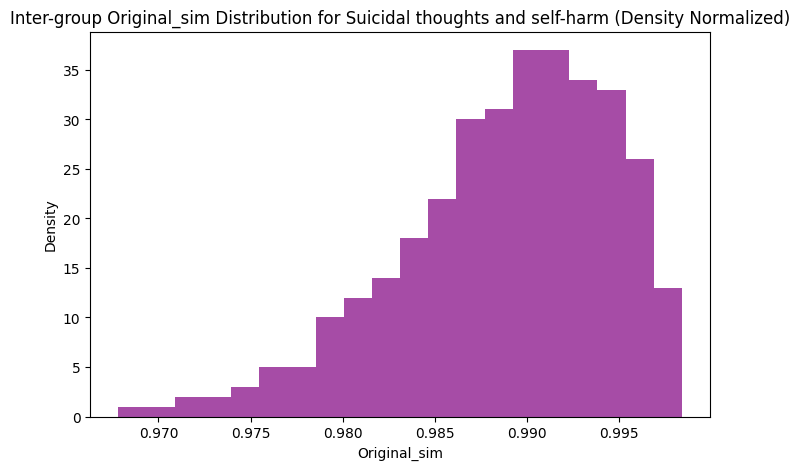

In [43]:
import matplotlib.pyplot as plt
from collections import defaultdict
import networkx as nx



# Choose the weight type: 'weight', 'nor_weight', or 'original_sim'
weight_type = 'original_sim'  

# Collect unique categories from node labels
categories = list(set(G.nodes[idx]['label'] for idx in G.nodes()))

# Collect intra-group and inter-group values based on the chosen weight
intra_sims = defaultdict(list)
inter_sims = defaultdict(list)

for u, v, data in G.edges(data=True):
    label_u = G.nodes[u]['label']
    label_v = G.nodes[v]['label']
    value = data[weight_type]
    if label_u == label_v:
        intra_sims[label_u].append(value)
    else:
        inter_sims[label_u].append(value)
        inter_sims[label_v].append(value)

# Define colors for each category
colors = {'Anxiety': 'blue', 'Depression': 'green', 'PTSD and trauma': 'red', 'Suicidal thoughts and self-harm': 'purple'}

# Define the order of categories (filter to only those present)
categories = [cat for cat in ["Anxiety", "Depression", "PTSD and trauma", "Suicidal thoughts and self-harm"] if cat in categories]

# Create separate figures for each category, showing intra then inter
for category in categories:
    # Plot intra-group if available
    if category in intra_sims and intra_sims[category]:
        plt.figure(figsize=(8, 5))
        plt.hist(intra_sims[category], bins=20, alpha=0.7, color=colors.get(category, 'gray'), density=False)
        plt.title(f"Intra-group {weight_type.capitalize()} Distribution for {category} (Density Normalized)")
        plt.xlabel(f"{weight_type.capitalize()}")
        plt.ylabel("Density")
        plt.show()
    
    # Plot inter-group if available
    if category in inter_sims and inter_sims[category]:
        plt.figure(figsize=(8, 5))
        plt.hist(inter_sims[category], bins=20, alpha=0.7, color=colors.get(category, 'gray'), density=False)
        plt.title(f"Inter-group {weight_type.capitalize()} Distribution for {category} (Density Normalized)")
        plt.xlabel(f"{weight_type.capitalize()}")
        plt.ylabel("Density")
        plt.show()

1. Compare Intra- vs. Inter-Category Similarities
 U-test, Permutation-test

In [59]:
import numpy as np
from scipy.stats import ttest_ind, mannwhitneyu
from sklearn.utils import shuffle  # For permutations
import networkx as nx



# Choose the weight type: 'weight', 'nor_weight', or 'original_sim'
weight_type = 'original_sim' 

# Extract node labels (main categories) from G (assuming nodes are indexed 0 to n-1)
nodes = sorted(G.nodes())
node_labels = [G.nodes[node]['label'] for node in nodes]
unique_labels = list(set(node_labels))
label_indices = {label: [i for i, lbl in enumerate(node_labels) if lbl == label] for label in unique_labels}

# Compute intra and inter values based on chosen weight
intra_sims = []
inter_sims = []
for i in range(len(node_labels)):
    for j in range(i + 1, len(node_labels)):  # Upper triangle, exclude self
        value = G[i][j][weight_type]
        if node_labels[i] == node_labels[j]:
            intra_sims.append(value)
        else:
            inter_sims.append(value)

print(f"Average Intra-Category {weight_type.capitalize()}: {np.mean(intra_sims):.4f}")
print(f"Average Inter-Category {weight_type.capitalize()}: {np.mean(inter_sims):.4f}")

# Statistical test (assume non-normal; use Mann-Whitney)
stat, p_value = mannwhitneyu(intra_sims, inter_sims, alternative='greater')
print(f"Mann-Whitney U Test: Statistic={stat:.2f}, p-value={p_value:.4f}")
if p_value < 0.05:
    print("Significant: Intra similarities are higher than inter, suggesting category-specific structure.")

print("===============================================================================")

import numpy as np
from scipy.stats import rankdata, norm

# Combine and rank (handles ties automatically)
all_sims = np.concatenate([intra_sims, inter_sims])
ranks = rankdata(all_sims)  # Average ranks for ties

ranks_intra = ranks[:len(intra_sims)]
ranks_inter = ranks[len(intra_sims):]

rank_sum_intra = np.sum(ranks_intra)
rank_sum_inter = np.sum(ranks_inter)

n1 = len(intra_sims)
n2 = len(inter_sims)
N = n1 + n2

# Corrected formulas
U_intra_manual = rank_sum_intra - (n1 * (n1 + 1) / 2)
U_inter_manual = rank_sum_inter - (n2 * (n2 + 1) / 2)

print(f"Manual U_intra: {U_intra_manual}")
print(f"Manual U_inter: {U_inter_manual}")

# Traditional U (minimum)
U = min(U_intra_manual, U_inter_manual)

# Expected U under null
exp_U = (n1 * n2) / 2

# Tie correction for variance
unique, counts = np.unique(all_sims, return_counts=True)
tie_sum = np.sum(counts**3 - counts)
if tie_sum > 0:
    correction = (N**3 - N - tie_sum) / (N * (N - 1))
else:
    correction = N + 1  # No ties: full (N+1)

var_U = (n1 * n2 / 12) * correction
std_U = np.sqrt(var_U)

# Z-score with continuity correction (for alternative='greater', since U_intra > exp_U)
Z = (U_intra_manual - exp_U - 0.5) / std_U

# One-tailed p-value
P = 1 - norm.cdf(Z)

# Print all requested values
print(f"Rank_sum_intra: {rank_sum_intra}")
print(f"number_of_intra: {n1}")
print(f"U_intra: {U_intra_manual}")

print(f"Rank_sum_inter: {rank_sum_inter}")
print(f"number_of_inter: {n2}")
print(f"U_inter: {U_inter_manual}")

print(f"U: {U}")
print(f"expected(U): {exp_U}")
print(f"standard(U): {std_U}")
print(f"Z: {Z}")
print(f"P: {P}")

print("\n===============================================================================\n")

# Permutation test for robustness (null: shuffle labels 1000 times)
observed_diff = np.mean(intra_sims) - np.mean(inter_sims)
perm_diffs = []
for _ in range(2000):
    shuffled_labels = shuffle(node_labels.copy())
    perm_intra, perm_inter = [], []
    for i in range(len(shuffled_labels)):
        for j in range(i + 1, len(shuffled_labels)):
            value = G[i][j][weight_type]  # Use chosen weight
            if shuffled_labels[i] == shuffled_labels[j]:
                perm_intra.append(value)
            else:
                perm_inter.append(value)
    perm_diffs.append(np.mean(perm_intra) - np.mean(perm_inter))
# perm_p = np.sum(np.abs(perm_diffs) >= np.abs(observed_diff)) / len(perm_diffs)
# Since you expect intra > inter, test if observed difference is unusually large
perm_p = np.sum(perm_diffs >= observed_diff) / len(perm_diffs)
print(f"Permutation Test p-value: {perm_p:.4f}")
if perm_p < 0.05:
    print("Reliable: Observed difference is significant vs. random label assignments.")

Average Intra-Category Original_sim: 0.9908
Average Inter-Category Original_sim: 0.9892
Mann-Whitney U Test: Statistic=67095.00, p-value=0.0000
Significant: Intra similarities are higher than inter, suggesting category-specific structure.
Manual U_intra: 67095.0
Manual U_inter: 45801.0
Rank_sum_intra: 85623.0
number_of_intra: 192
U_intra: 67095.0
Rank_sum_inter: 218967.0
number_of_inter: 588
U_inter: 45801.0
U: 45801.0
expected(U): 56448.0
standard(U): 2710.6545335029323
Z: 3.9276491594233924
P: 4.2890110468651876e-05


Permutation Test p-value: 0.0000
Reliable: Observed difference is significant vs. random label assignments.


2. Cliff's Delta (Effect Size)

In [45]:
import numpy as np


weight_type='original_sim'


# Recompute if needed (from your earlier code)
node_labels = [topic['model_label'] for topic in all_subtopics]

# Ensure node indices align with all_subtopics
nodes = list(G.nodes())
if len(nodes) != len(all_subtopics):
    raise ValueError("Number of nodes in G must match length of all_subtopics")


# Collect intra- and inter-community similarities
intra_sims = []
inter_sims = []
for i, node_i in enumerate(nodes):
    for j, node_j in enumerate(nodes[i + 1:], start=i + 1):
        # Get similarity (edge weight) from graph G
        sim = G[node_i][node_j].get(weight_type, 0.0) if G.has_edge(node_i, node_j) else 0.0
        # Compare community labels
        if node_labels[i] == node_labels[j]:
            intra_sims.append(sim)
        else:
            inter_sims.append(sim)



def cliffs_delta(x, y):
    # Efficient vectorized version (avoids double loop for large data)
    x = np.array(x)
    y = np.array(y)
    gt = np.sum(x[:, np.newaxis] > y[np.newaxis, :])
    lt = np.sum(x[:, np.newaxis] < y[np.newaxis, :])
    eq = np.sum(x[:, np.newaxis] == y[np.newaxis, :])  # Ties count as 0
    return (gt - lt) / (len(x) * len(y))

delta = cliffs_delta(intra_sims, inter_sims)
print(f"Cliff's Delta: {delta:.4f}")
if delta > 0.474:
    print("Large effect: Strong category-specific structure.")
elif delta > 0.33:
    print("Medium effect.")
elif delta > 0.147:
    print("Small effect.")
elif delta > 0:
    print("Negligible positive effect.")
else:
    print("No or negative effect.")

Cliff's Delta: 0.1886
Small effect.


3. Graph Modularity and Comparison to Null Models (Structure Reliability)

In [46]:
import networkx as nx
from networkx.algorithms.community import modularity
from collections import defaultdict
import numpy as np
import pickle
import os


# Extract upper triangular similarity values (exclude diagonal)
n = len(all_subtopics)
similarities = []
for i in range(n):
    for j in range(i + 1, n):
        similarities.append(sim_matrix[i, j])

similarities = np.array(similarities)

# get the median of all the similarity 
median = np.median(similarities)
print(f"median: {median}")

mean = np.mean(similarities)
print(f"mean: {mean}")

# get the std from all the similarity 
std = np.std(similarities)
print(f"std: {std}")

sim_threshold = 0.993
# sim_threshold = median + std
print(f"sim_threshold: {sim_threshold}")

print("================================================================")


# Add colors to existing G nodes if not present
from matplotlib.cm import get_cmap
cmap = get_cmap("tab10", len(labels))
label_color = {label: cmap(i) for i, label in enumerate(labels)}
for n in G.nodes:
    if 'color' not in G.nodes[n]:
        node_label = G.nodes[n]['label']
        G.nodes[n]['color'] = label_color[node_label]

# Filter edges based on original_sim >= sim_threshold
filtered_edges = [(u, v) for u, v, d in G.edges(data=True) if d['original_sim'] >= 0.994]
filtered_G = G.edge_subgraph(filtered_edges).copy()

# Network statistics
edge_count = filtered_G.number_of_edges()
print(f"\nNetwork statistics:")
print(f"  Total nodes: {filtered_G.number_of_nodes()}")
print(f"  Total edges: {edge_count}")
print(f"  Edge density: {edge_count / (n * (n-1) // 2):.4f}")

print("================================================================")




# Modularity using node labels as communities
communities = defaultdict(list)
for node, data in filtered_G.nodes(data=True):
    communities[data['label']].append(node)
community_list = list(communities.values())


obs_mod = modularity(filtered_G, community_list,weight="original_sim")
# print(f"Observed Modularity: {obs_mod:.4f} (higher than 0.3-0.7 is good for real networks)")
print("higher than 0.3-0.7 is good for real networks")


obs_mod_weighted = modularity(filtered_G, community_list, weight="weight")
print("Weighted Modularity:", obs_mod_weighted)


obs_mod_unweighted = modularity(filtered_G, community_list, weight=None)
print("Unweighted Modularity:", obs_mod_unweighted)


obs_mod_weighted = modularity(filtered_G, community_list, weight="nor_weight")
print("normalized weight Modularity:", obs_mod_weighted)

obs_mod_weighted = modularity(filtered_G, community_list, weight="original_sim")
print("original_sim_Weighted Modularity:", obs_mod_weighted)





print("================================================================")

# Null model test
if filtered_G.number_of_edges() > 0:
    print(f"\nNull model test:")
    degrees = [d for n, d in filtered_G.degree()]
    null_mods = []
    n_permutations = 1000
    
    for _ in range(n_permutations):
        try:
            null_G = nx.configuration_model(degrees)
            null_G = nx.Graph(null_G)  # Remove multi-edges/self-loops
            if null_G.number_of_edges() > 0:
                null_mod = modularity(null_G, community_list, weight="original_sim")
            else:
                null_mod = 0.0
            null_mods.append(null_mod)
        except:
            null_mods.append(0.0)
    
    null_mean = np.mean(null_mods)
    null_p = np.sum(np.array(null_mods) >= obs_mod) / len(null_mods)
    
    print(f"  Null mean modularity: {null_mean:.4f}")
    print(f"  p-value: {null_p:.4f}")
    
    if null_p < 0.05:
        print("  Result: Significant community structure (p < 0.05)")
        print("  ✓ Mental health topic clustering is significantly better than random")
    else:
        print("  Result: No significant community structure (p >= 0.05)")
        print("  ✗ Mental health topic clustering is not significantly different from random")
else:
    print("\nNo edges in graph, cannot perform null model test.")





median: 0.9904305415003805
mean: 0.989560871735176
std: 0.005286900856451168
sim_threshold: 0.993

Network statistics:
  Total nodes: 40
  Total edges: 168
  Edge density: 0.2267
higher than 0.3-0.7 is good for real networks
Weighted Modularity: 0.037398802852385796
Unweighted Modularity: 0.02108134920634919
normalized weight Modularity: 0.0369165817509742
original_sim_Weighted Modularity: 0.021011176806804224

Null model test:


C:\Users\user\AppData\Local\Temp\ipykernel_31396\2310607707.py:38: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = get_cmap("tab10", len(labels))


  Null mean modularity: 0.0009
  p-value: 0.2490
  Result: No significant community structure (p >= 0.05)
  ✗ Mental health topic clustering is not significantly different from random


4. assortativity mating

In [47]:
import networkx as nx
import numpy as np




# filtered_G = G  # Replace with actual filtered_G if different

def weighted_attribute_assortativity_coefficient(G, attribute, weight_attr=None):
    """Compute weighted attribute assortativity coefficient.
    
    If weight_attr is None, computes unweighted (equivalent to built-in).
    """
    # Get mapping of attributes to indices
    attr_values = set(nx.get_node_attributes(G, attribute).values())
    mapping = {val: idx for idx, val in enumerate(sorted(attr_values))}
    num_classes = len(mapping)
    
    # Initialize mixing matrix M (sum of weights from class i to j, directed sense)
    M = np.zeros((num_classes, num_classes))
    
    # Total "directed" weight (will be 2 * sum edge weights for undirected)
    total_weight = 0.0
    
    for u, v, data in G.edges(data=True):
        if attribute in G.nodes[u] and attribute in G.nodes[v]:
            au = mapping[G.nodes[u][attribute]]
            av = mapping[G.nodes[v][attribute]]
            w = data.get(weight_attr, 1.0) if weight_attr else 1.0
            M[au, av] += w
            M[av, au] += w  # Treat as two directed edges
            total_weight += 2 * w
    
    if total_weight == 0:
        return 0.0
    
    # Normalize to get e
    e = M / total_weight
    
    # Compute a_i (row sums, should be same as column sums)
    a = np.sum(e, axis=1)
    
    # Trace of e (sum e_ii)
    tr_e = np.trace(e)
    
    # sum a_i^2
    sum_a2 = np.dot(a, a)
    
    # Assortativity r
    if 1 - sum_a2 == 0:
        r = 0.0
    else:
        r = (tr_e - sum_a2) / (1 - sum_a2)
    
    return r

# List of weight types (None for unweighted)
weight_types = [None, 'weight', 'nor_weight', 'original_sim']

print("\nAssortativity Test for Different Weights:")
for wt in weight_types:
    if wt is None:
        # Use built-in for unweighted to verify
        assortativity_score = nx.attribute_assortativity_coefficient(filtered_G, "label")
        wt_name = "unweighted"
    else:
        assortativity_score = weighted_attribute_assortativity_coefficient(filtered_G, "label", weight_attr=wt)
        wt_name = wt
    print(f"  Weight: {wt_name}")
    print(f"    Assortativity coefficient (r): {assortativity_score:.4f}")
    if assortativity_score > 0.3:
        print("    ✓ Strong assortative mixing (nodes prefer same community)")
    elif assortativity_score > 0:
        print("    ✓ Weak assortative mixing")
    elif assortativity_score == 0:
        print("    ~ No assortativity (random connections)")
    else:
        print("    ✗ Disassortative mixing (nodes prefer cross-community edges)")


    print("==================================================================")



Assortativity Test for Different Weights:
  Weight: unweighted
    Assortativity coefficient (r): 0.0287
    ✓ Weak assortative mixing
  Weight: weight
    Assortativity coefficient (r): 0.0514
    ✓ Weak assortative mixing
  Weight: nor_weight
    Assortativity coefficient (r): 0.0508
    ✓ Weak assortative mixing
  Weight: original_sim
    Assortativity coefficient (r): 0.0286
    ✓ Weak assortative mixing


In [ ]:
try:
    from gensim.models.coherencemodel import CoherenceModel
    from gensim.corpora.dictionary import Dictionary
except ImportError:
    print("gensim not available. Install it to use this metric.")
else:
    # Prepare a "corpus" from all keywords (as proxy; list of lists)
    all_keywords = [[kw for kw, _ in t['keywords'][:10]] for t in all_subtopics]
    dictionary = Dictionary(all_keywords)

    def paired_coherence(topic1_keywords, topic2_keywords, top_n=10):
        combined = list(set([kw for kw, _ in topic1_keywords[:top_n]] + [kw for kw, _ in topic2_keywords[:top_n]]))
        if len(combined) < 2:
            return 0.0
        cm = CoherenceModel(topics=[combined], texts=all_keywords, dictionary=dictionary, coherence='c_v')
        return cm.get_coherence()

    # Compute for all edges
    edge_coherences = {}
    for u, v in filtered_G.edges:
        topic_u = all_subtopics[u]
        topic_v = all_subtopics[v]
        coherence = paired_coherence(topic_u['keywords'], topic_v['keywords'])
        edge_coherences[(u, v)] = coherence
        print(f"Edge ({topic_u['name']}, {topic_v['name']}) - Similarity: {filtered_G[u][v]['original_sim']:.4f}, Paired Coherence: {coherence:.4f}")

    # Summary stats
    if edge_coherences:
        avg_coherence = np.mean(list(edge_coherences.values()))
        print(f"Average Paired Coherence for connected edges: {avg_coherence:.4f}")

Edge (Job Stress, Medication Effects) - Similarity: 0.9961, Paired Coherence: 0.4601
Edge (Job Stress, Withdrawal Treatment Challenges) - Similarity: 0.9951, Paired Coherence: 0.1398
Edge (Job Stress, Relationship Energy Drains) - Similarity: 0.9979, Paired Coherence: 0.1267
Edge (Job Stress, Inner Dialogue) - Similarity: 0.9930, Paired Coherence: 0.0636
Edge (Job Stress, Support Skepticism) - Similarity: 0.9952, Paired Coherence: 0.1796
Edge (Job Stress, Therapy Healing Fears) - Similarity: 0.9975, Paired Coherence: 0.3892
Edge (Job Stress, Abusive Hurt Protection) - Similarity: 0.9939, Paired Coherence: 0.2035
Edge (Job Stress, Childhood Anger Trust) - Similarity: 0.9944, Paired Coherence: 0.1832
Edge (Job Stress, Financial Strain) - Similarity: 0.9966, Paired Coherence: 0.1421
Edge (Job Stress, Pain Flashback Anger) - Similarity: 0.9966, Paired Coherence: 0.1521
Edge (Job Stress, Sexual Abuse) - Similarity: 0.9950, Paired Coherence: 0.1420
Edge (Job Stress, Family Hurt) - Similarity

In [48]:
import networkx as nx
from networkx.algorithms.community import modularity, greedy_modularity_communities
from collections import defaultdict




weight_type = "original_sim"


# Predefined communities based on model_label
predefined_communities = defaultdict(list)
for node, data in filtered_G.nodes(data=True):
    predefined_communities[data['label']].append(node)

# New communities from greedy modularity
new_communities = list(greedy_modularity_communities(filtered_G, weight=weight_type))
print(f"\nDetected {len(new_communities)} communities.")

# Map nodes to their new community IDs
node_to_new_comm = {node: i for i, comm in enumerate(new_communities) for node in comm}

# Print new communities with subtopic names
print("\nNew Communities (from Greedy Modularity):")
for i, comm in enumerate(new_communities):
    print(f"Community {i}:")
    for node in comm:
        topic = filtered_G.nodes[node]['name']
        print(f"  - {topic}")

# Compare predefined and new communities for each node
print("\nNode Community Assignments (Predefined vs. New):")
print(f"{'Subtopic':<30} {'Predefined Community':<25} {'New Community':<40}")
print("-" * 95)
for node in filtered_G.nodes:
    topic = filtered_G.nodes[node]['name']
    predefined_label = filtered_G.nodes[node]['label']
    new_comm_id = node_to_new_comm[node]
    print(f"{topic:<30} {predefined_label:<25} Community {new_comm_id:<40}")






# Modularity for new communities
mod_score = modularity(filtered_G, new_communities, weight=weight_type)
print(f"\nGraph Modularity (New Communities): {mod_score:.4f}")




# Modularity for predefined communities
predefined_comm_list = list(predefined_communities.values())
obs_mod = modularity(filtered_G, predefined_comm_list, weight=weight_type)
print(f"Observed Modularity (Predefined Communities): {obs_mod:.4f}")


Detected 5 communities.

New Communities (from Greedy Modularity):
Community 0:
  - Home Relations
  - Work Stress
  - Family Issues
  - Family Drains
  - Bipolar Medication
  - Financial Stress
  - Family Abuse
  - Therapy Healing Fears
  - Abusive Hurt Protection
  - Childhood Anger Trust
  - Financial Strain
  - Masked Trauma
  - Family Hurt
  - Suicidal Loss
  - Financial Stress
  - Workplace Strain
Community 1:
  - Community Support
  - OCD Night Safety
  - Sleep Coping
  - Community Sharing
  - Support Skepticism
  - Sexual Abuse
  - Self-Harm Support
  - Hesitant Pain Skepticism
  - Family Hurt Trust
Community 2:
  - Safety Plan Trusts
  - Inner Struggles
  - Parental Conflict
  - ADHD Medication
  - Hopelessness
  - Pain Flashback Anger
  - Low Energy
Community 3:
  - Panic Symptoms
  - Uncertainty Skepticism
  - Medication Effects
  - Withdrawal Challenges
  - Cognitive Symptoms
Community 4:
  - Anxiety Sadness
  - Lonely Family
  - Friendship Struggles

Node Community Assign

Regression model 

line plot for whole main topics 

(11573, 12)
Missing values in 'year' column: 0


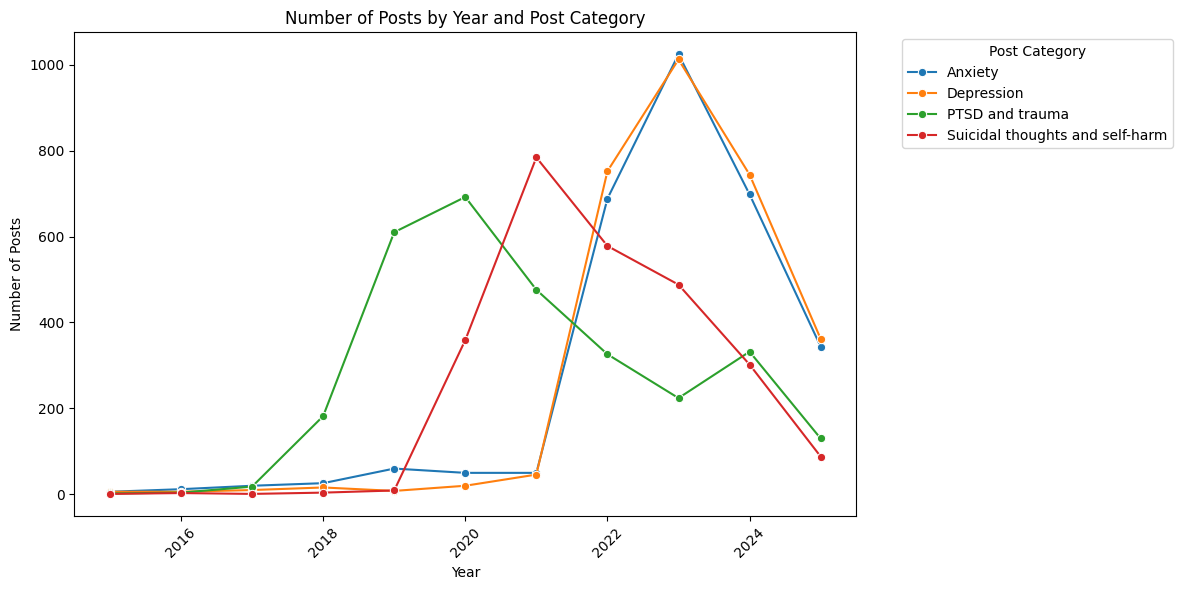

In [47]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import seaborn as sns


current_dir = os.getcwd()
platform = "beyondblue"
labels = ["Anxiety", "Depression", "PTSD and trauma", "Suicidal thoughts and self-harm"]


main_symptoms_df = []
for label in labels:
    df = pd.read_csv(os.path.join(current_dir, 'data',f'{platform}_data','berttopic_label',f'{label}','label_df.csv'))
    main_symptoms_df.append(df)

main_symptoms_df = pd.concat(main_symptoms_df, ignore_index=True)
main_symptoms_df['year'] = pd.to_datetime(main_symptoms_df['Post Date']).dt.year
main_symptoms_df['Post Category'] = main_symptoms_df['Post Category'].str.strip()

print(main_symptoms_df.shape)
# check how many missing value in the year column
print("Missing values in 'year' column:", main_symptoms_df['year'].isna().sum())






# Group and count number of posts per year per category
post_counts = main_symptoms_df.groupby(['year', 'Post Category']).size().reset_index(name='Post Count')

# Now plot
plt.figure(figsize=(12, 6))
sns.lineplot(data=post_counts, x='year', y='Post Count', hue='Post Category', marker='o')
plt.title('Number of Posts by Year and Post Category')
plt.xlabel('Year')
plt.ylabel('Number of Posts')
plt.xticks(rotation=45)
plt.legend(title='Post Category', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

line plot for  subtopics for each main topics

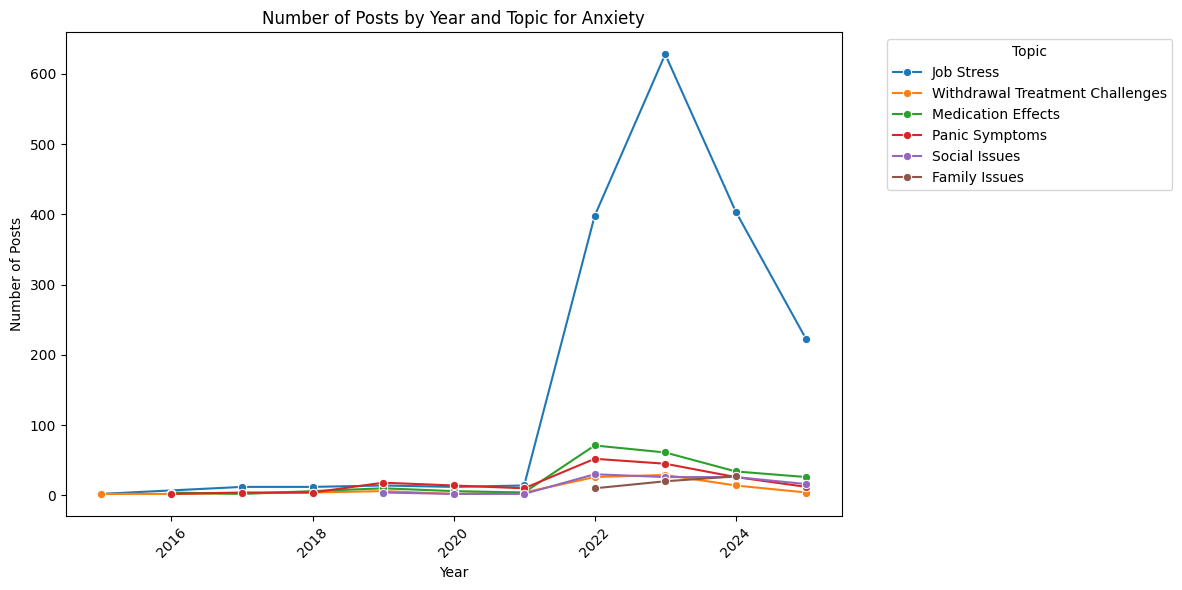

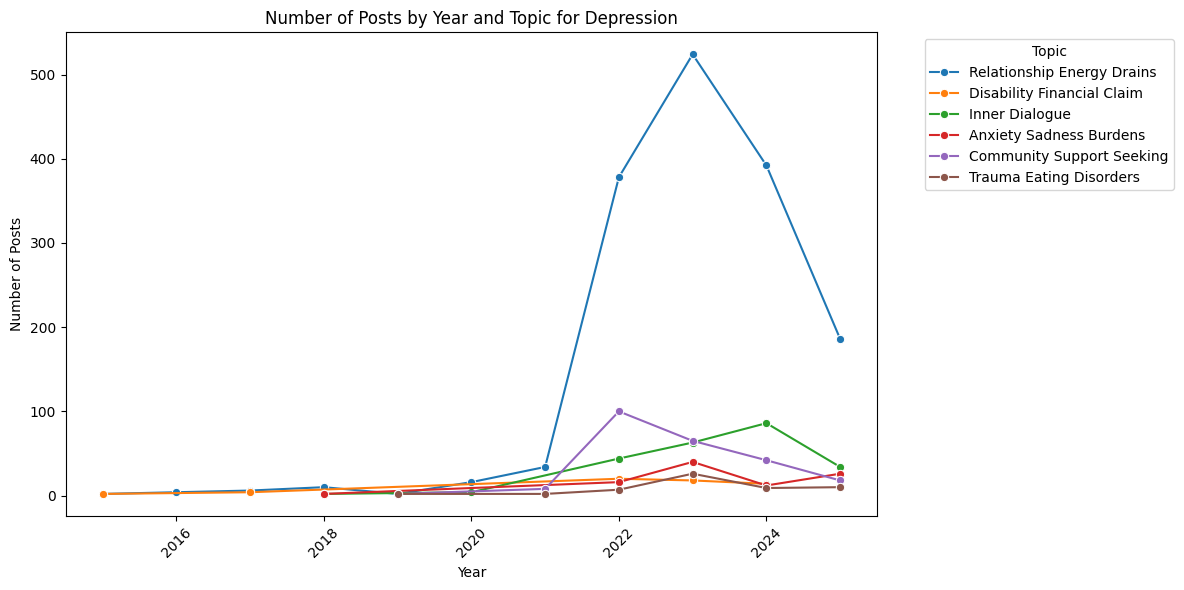

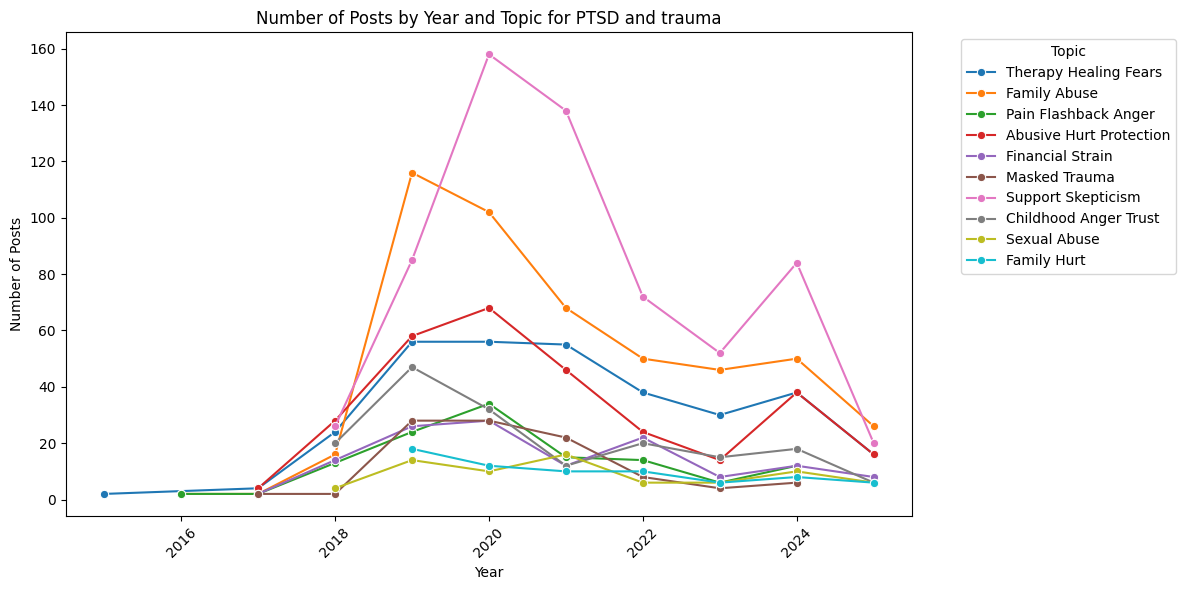

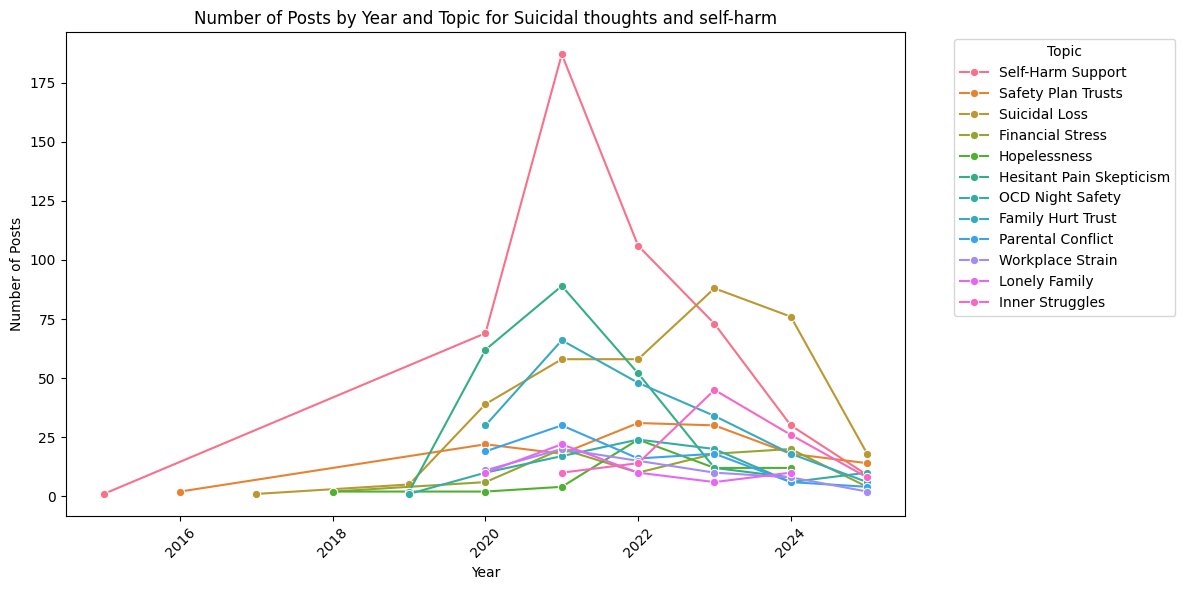

In [3]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import seaborn as sns



current_dir = os.getcwd()
platform = "beyondblue"
labels = ["Anxiety", "Depression", "PTSD and trauma", "Suicidal thoughts and self-harm"]



for label in labels:
    df = pd.read_csv(os.path.join(current_dir, 'data',f'{platform}_data','berttopic_label',f'{label}',f'{label}_topic_docs.csv'))

    # draw the line plot according to the number of posts for each topic(custome topic) by year excludinf -1 topic
    df['year'] = pd.to_datetime(df['Post Date']).dt.year
    df = df[df['Topic'] != -1]  # Exclude outliers
    topic_counts = df.groupby(['year', 'Topic']).size().reset_index(name='Post Count')
    topic_counts['Topic'] = topic_counts['Topic'].replace(custom_names_dict[label])
    plt.figure(figsize=(12, 6))
    sns.lineplot(data=topic_counts, x='year', y='Post Count', hue='Topic', marker='o')
    plt.title(f'Number of Posts by Year and Topic for {label}')
    plt.xlabel('Year')
    plt.ylabel('Number of Posts')
    plt.xticks(rotation=45)
    plt.legend(title='Topic', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    # plt.savefig(os.path.join(current_dir, 'data', f'{platform}_data', 'berttopic_label', f'{label}', f'{label}_topic_yearly_counts.png'))
    plt.show()
    
    

    